In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import random as rand
import seaborn as sns
import pandas as pd
import math
from sklearn.preprocessing import StandardScaler

In [ ]:
def convertirACadena(num):
    return '{:032b}'.format(int(num))

def convEnt(num):
    return '{:05b}'.format(int(num))

def generaComplementarias(numero):
    generados = 0
    funcComp = []
    while generados < numero:
        funcRand = rand.randint(0, 2**32-1)
        if funcRand not in funciones:
            funcComp.append(funcRand)
            generados += 1
    return funcComp

def leeFunciones(nombreFichero):
    funciones = np.genfromtxt(nombreFichero, dtype = float, usecols=0, unpack=True)
    funcionesStr = np.genfromtxt(nombreFichero, dtype = str, usecols=1, unpack=True)
    return funciones, funcionesStr

def normaliza(valores, minimo, maximo):
    return (valores - minimo) /(maximo - minimo)

def puntuacionRepeticiones(segmentos):
    puntuacion = 0
    for elem in set(segmentos):
        apariciones = segmentos.count(elem)
        if apariciones > 1:
            puntuacion += apariciones*len(elem)
    return puntuacion

def repetitividad(s):
    puntRepGlobal = 0
    posActual = 0
    segmentos = []
    for num in [4,4,4,4,4,4,4,4]:
        segmentos.append(s[posActual:posActual+num])
        posActual += num
    return puntuacionRepeticiones(segmentos)

def calculaRepetitividades(funciones):
    return np.array([repetitividad(convertirACadena(s)) for s in funciones])

def cerosFuncion(funcion):
    return [i for i in range(32) if funcion[i] == '0']

def unosFuncion(funcion):
    return [i for i in range(32) if funcion[i] == '1']

def diferenciaPar(par1,par2):
    diferencias1 = ""
    diferencias2 = ""
    contexto = ""
    posiciones = []
    for i in range(len(par1)):
        if par1[i] != par2[i]:
            diferencias1 += par1[i]
            diferencias2 += par2[i]
            posiciones.append(i)
        else:
            contexto += par1[i]
    return diferencias1, diferencias2, posiciones, par1, par2, contexto

def coincidenPar(cad1,cad2):
    return sum(map(lambda x,y: x==y, cad1, cad2))

def puntuacionDistParesFuncion(funcion):
    saca0 = cerosFuncion(funcion)
    saca1 = unosFuncion(funcion)
    punt = 0
    distintosAlMenos2 = []
    for fun0 in saca0:
        for fun1 in saca1:
            dif1, dif2, pos, par1, par2, contexto = diferenciaPar(convEnt(fun0),convEnt(fun1))
            distintosAlMenos2.append((dif1,dif2,pos,par1,par2,contexto))
    cruces = 0
    for i in range(len(distintosAlMenos2)):
        dif1, dif2, pos, par1, par2, contexto = distintosAlMenos2[i]
        for j in range(i, len(distintosAlMenos2)):
            dif1bis, dif2bis, posbis, par1bis, par2bis, contextobis = distintosAlMenos2[j]
            if dif1 == dif2bis and dif2 == dif1bis and pos == posbis:
                    cruces += 5-len(dif1)
                    cruces += coincidenPar(contexto,contextobis)/len(contexto)
    return cruces

def puntuacionDistPares(funciones):
    return np.array([puntuacionDistParesFuncion(convertirACadena(funcion)) for funcion in funciones])


def pruebaCombinacionMetricasParam(nMuestra, funciones, parametros):
    # Muestras de entrenamiento
    muestraData = np.random.choice(funciones, nMuestra)
    muestraComp = generaComplementarias(nMuestra)

    puntParesData = puntuacionDistPares(muestraData)
    puntParesComp = puntuacionDistPares(muestraComp)
    minimo = min(np.min(puntParesData), np.min(puntParesComp))
    maximo = max(np.max(puntParesData), np.max(puntParesComp))
    puntParesDataNorm = normaliza(puntParesData, minimo, maximo)
    puntParesCompNorm = normaliza(puntParesComp, minimo, maximo)

    puntRepData = calculaRepetitividades(muestraData)
    puntRepComp = calculaRepetitividades(muestraComp)
    puntRepDataNorm = normaliza(puntRepData, 0, 32)
    puntRepCompNorm = normaliza(puntRepComp, 0, 32)

    plt.title("Funciones del dataset")
    plt.xlabel('Función')
    plt.ylabel('Puntuación reescalada')
    plt.scatter(muestraData, puntRepDataNorm, marker = 'x', color = 'blue', label = 'Puntuación repetitividad')
    plt.scatter(muestraData, puntParesDataNorm, marker = '.', color = 'red', label ='Puntuación diferenciación pares')
    plt.legend(loc = 'upper right')
    plt.savefig('puntuacionesCombEntrenoData.pdf')
    plt.show()

    plt.title("Funciones del complementario")
    plt.xlabel('Función')
    plt.ylabel('Puntuación reescalada')
    plt.scatter(muestraComp, puntRepCompNorm, marker = 'x', color = 'blue', label = 'Puntuación repetitividad')
    plt.scatter(muestraComp, puntParesCompNorm, marker = '.', color = 'red', label ='Puntuación diferenciación pares')
    plt.legend(loc = 'upper right')
    plt.savefig('puntuacionesCombEntrenoComp.pdf')
    plt.show()

    for alpha, beta in parametros:
            # Calculo de la combinacion de puntuaciones
            puntDataComb = alpha * puntRepDataNorm + beta * puntParesDataNorm
            puntCompComb = alpha * puntRepCompNorm + beta * puntParesCompNorm
            # Normalizacion de la combinación
            puntDataCombNorm = normaliza(puntDataComb, beta, alpha)
            puntCompCombNorm = normaliza(puntCompComb, beta, alpha)
            # Histograma de puntuaciones
            plt.figure(1)
            plt.hist(puntDataCombNorm, bins='auto', alpha = 0.5, label='dataset')
            plt.hist(puntCompCombNorm, bins='auto', alpha = 0.5, label='complementario')
            plt.title('Puntuaciones de la combinación con alpha = {} y beta = {} normalizadas'.format(alpha,beta))
            plt.xlabel("Puntuación")
            plt.ylabel("Nº veces con esa puntuacion")
            plt.savefig('distribucionCombinacion{}{}.pdf'.format(alpha,beta))
            plt.show()
            # Test de acierto
            muestraDataTest = np.random.choice(funciones, nMuestra)
            muestraCompTest = generaComplementarias(nMuestra)
            puntParesDataTest = puntuacionDistPares(muestraDataTest)
            puntParesCompTest = puntuacionDistPares(muestraCompTest)
            puntParesDataTestNorm = normaliza(puntParesDataTest, minimo, maximo)
            puntParesCompTestNorm = normaliza(puntParesCompTest, minimo, maximo)
            puntRepDataTest = calculaRepetitividades(muestraDataTest)
            puntRepCompTest = calculaRepetitividades(muestraCompTest)
            puntRepDataNormTest = normaliza(puntRepDataTest, 0, 32)
            puntRepCompNormTest = normaliza(puntRepCompTest, 0, 32)
            puntDataCombTest = alpha * puntRepDataNorm + beta * puntParesDataNorm
            puntCompCombTest = alpha * puntRepCompNorm + beta * puntParesCompNorm
            puntDataCombTestNorm = normaliza(puntDataCombTest, beta, alpha)
            puntCompCombTestNorm = normaliza(puntCompCombTest, beta, alpha)
            mediaData = np.mean(puntDataCombNorm)
            mediaComp = np.mean(puntCompCombNorm)
            aciertoData = np.sum(np.abs(puntDataCombTestNorm - mediaData) <= np.abs(puntDataCombTestNorm - mediaComp))/nMuestra
            aciertoComp = np.sum(np.abs(puntCompCombTestNorm - mediaComp) <= np.abs(puntCompCombTestNorm - mediaData))/nMuestra
            print('Con alpha = {} y beta = {}, acierto del dataset: {} %, acierto del complementario: {} %'.format(alpha,beta,aciertoData*100, aciertoComp*100))


In [ ]:
funciones,_  = leeFunciones('/content/drive/MyDrive/TFG/funcionesSinRepeticion.txt')

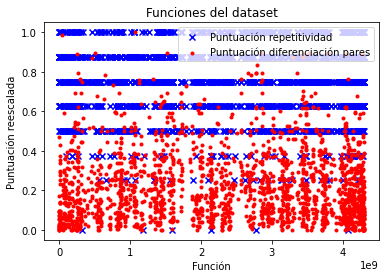

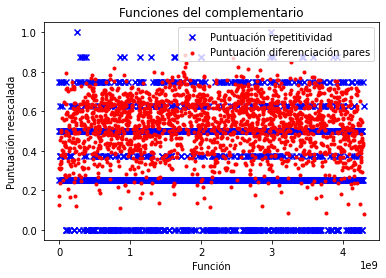

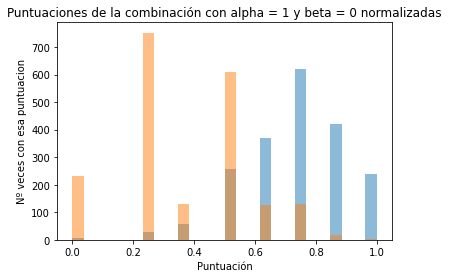

Con alpha = 1 y beta = 0, acierto del dataset: 82.69999999999999 %, acierto del complementario: 86.15 %


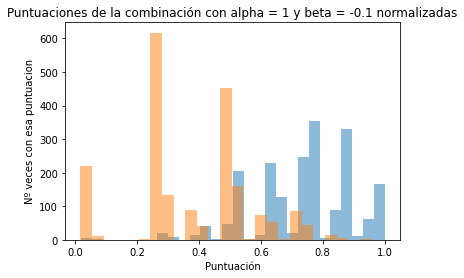

Con alpha = 1 y beta = -0.1, acierto del dataset: 82.69999999999999 %, acierto del complementario: 86.15 %


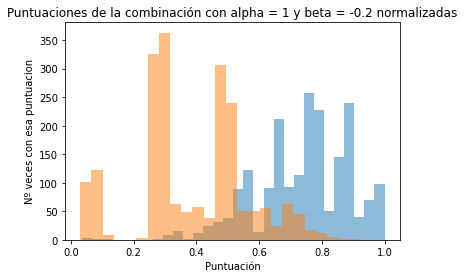

Con alpha = 1 y beta = -0.2, acierto del dataset: 85.55 %, acierto del complementario: 86.1 %


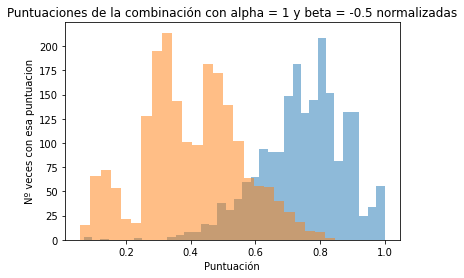

Con alpha = 1 y beta = -0.5, acierto del dataset: 89.8 %, acierto del complementario: 87.3 %


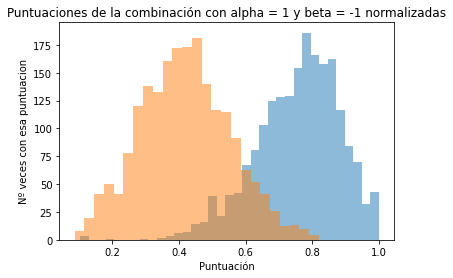

Con alpha = 1 y beta = -1, acierto del dataset: 90.35 %, acierto del complementario: 89.1 %


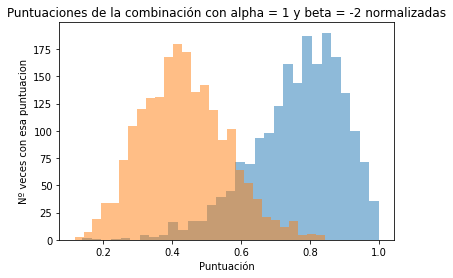

Con alpha = 1 y beta = -2, acierto del dataset: 88.4 %, acierto del complementario: 90.10000000000001 %


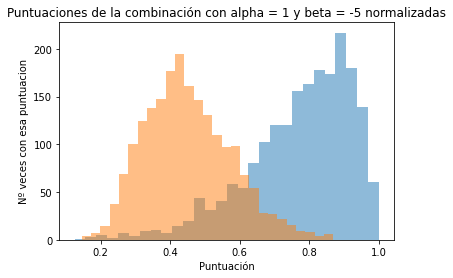

Con alpha = 1 y beta = -5, acierto del dataset: 85.65 %, acierto del complementario: 89.4 %


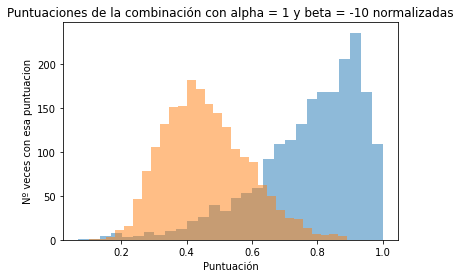

Con alpha = 1 y beta = -10, acierto del dataset: 84.65 %, acierto del complementario: 88.3 %


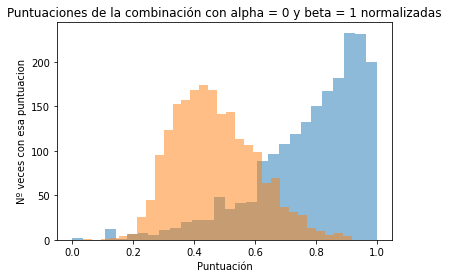

Con alpha = 0 y beta = 1, acierto del dataset: 82.89999999999999 %, acierto del complementario: 86.6 %


In [ ]:
parametros = [(1,0),(1,-0.1),(1,-0.2),(1,-0.5),(1,-1),(1,-2),(1,-5),(1,-10), (0,1)]
pruebaCombinacionMetricasParam(2000, funciones, parametros)

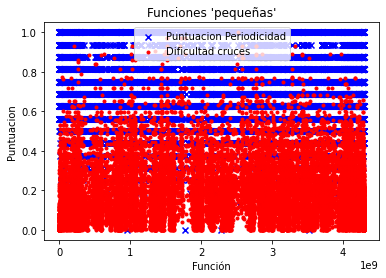

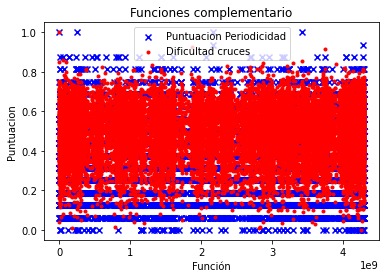

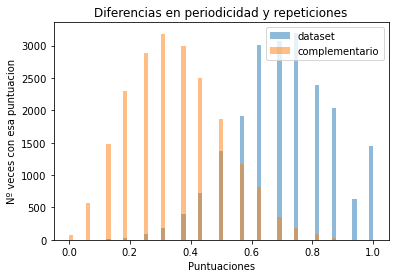

Media normalizada del data set: 0.705533066718689
Media normalizada complementario 0.3498433232539992
Diferencia absoluta 0.3556897434646898
Dev.Dataset 0.15982251598666344    Desv.Comp 0.15661116517804646
Margen 0.03925606229997994



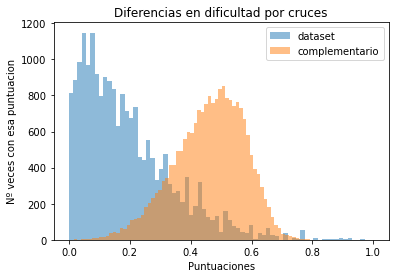

Media normalizada del data set: 0.19081040206084895
Media normalizada complementario 0.46198539851302683
Diferencia absoluta 0.2711749964521779
Dev.Dataset 0.1514875217107381    Desv.Comp 0.11527329980427614
Margen 0.004414174937163645



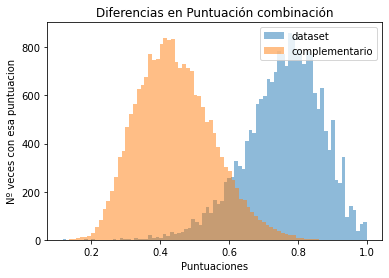

Media normalizada del data set: 0.75736133232892
Media normalizada complementario 0.4439289623704862
Diferencia absoluta 0.3134323699584338
Dev.Dataset 0.11031406367275469    Desv.Comp 0.10967634425465463
Margen 0.09344196203102446



In [ ]:
pruebaCombinacionMetricas(1, 100, funciones, combinaciones, cuentaLong = True, muestra = False, usaContexto = True)